In [130]:
#import various libraries, we mostly use functions from statsmodels here
# Tells matplotlib to display images inline instead of a new window
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
plt.style.use('ggplot')
import statsmodels.api as sm
import random
import warnings
import itertools
from statsmodels.tsa.api import acf, graphics, pacf

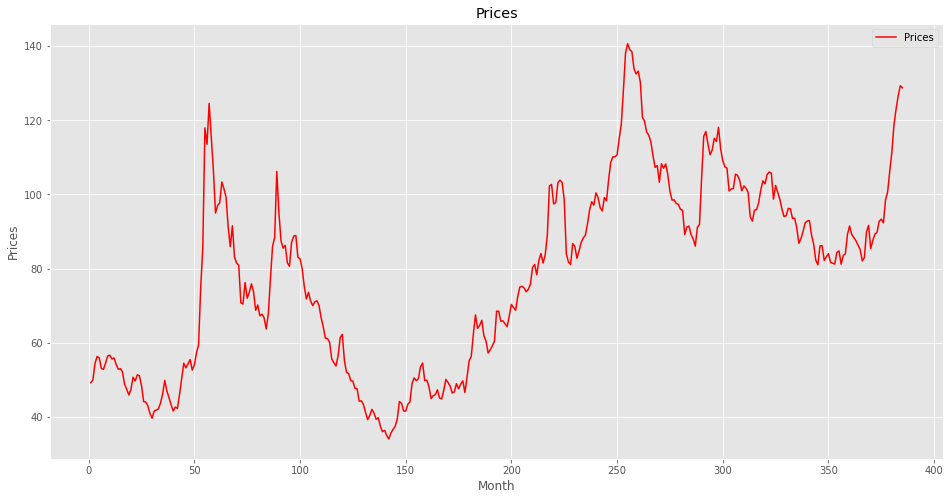

In [131]:
# read data of Coffee Prices
coffeeprice = np.genfromtxt("CoffeePrice.csv", delimiter = ",")
# get month and price  values
month= coffeeprice[:,0].astype(int)
prices= coffeeprice[:,1] 
plt.figure(figsize = (16, 8))
# the prices data in red
plt.plot(month,prices, 'r') 
plt.xlabel("Month")
plt.ylabel("Prices")
plt.title("Prices")
plt.legend(['Prices'])
plt.show()

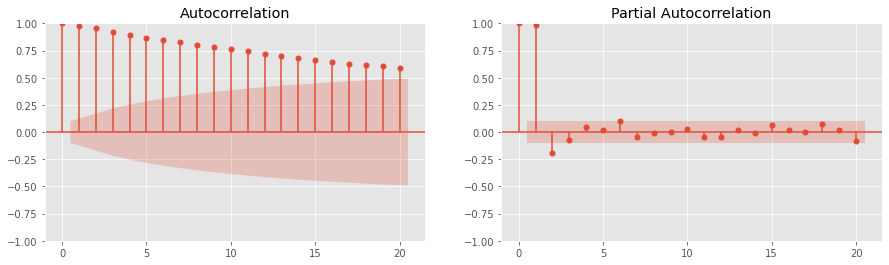

In [132]:
#plotting ACF and PACF of general data in order to see if there is a corralation between data
fig, axes = plt.subplots(1, 2, figsize=(15,4))
fig = sm.graphics.tsa.plot_acf(prices, lags=20, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(prices, lags=20, ax=axes[1])

In [133]:
#detrending the data since there is an upward trend or longterm independent long trends
print(len(prices))
sdiffprices=[0]*len(prices)
drprices = np.diff(prices)

385


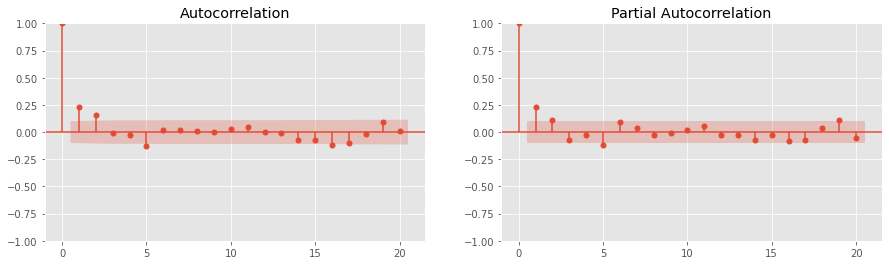

In [134]:
#plotting ACF and PACF of detrended data
fig, axes = plt.subplots(1, 2, figsize=(15,4))
fig = sm.graphics.tsa.plot_acf(drprices, lags=20, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(drprices, lags=20, ax=axes[1])

In [135]:
# Fit a model based on the ACF and PACF plots 
AR2 = sm.tsa.statespace.SARIMAX(prices, trend ='c', order=(2, 1,0 ),
                                seasonal_order=(0, 0, 0, 0))
results_ar2 = AR2.fit()
results_ar2.summary()
#seems like intercept term is not statistically significant

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  385
Model:               SARIMAX(2, 1, 0)   Log Likelihood               -1071.722
Date:                Mon, 04 Apr 2022   AIC                           2151.443
Time:                        19:18:50   BIC                           2167.246
Sample:                             0   HQIC                          2157.711
                                - 385                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1432      0.233      0.615      0.539      -0.313       0.600
ar.L1          0.2079      0.028      7.529      0.000       0.154       0.262
ar.L2          0.1099      0.035      3.109      0.002       0.041       0.179
sigma2        15.5459      0.630     24.686      0.000      14.312      16.780
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):              1124.85
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.41   Skew:                             0.93
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [136]:
#  evaluation of  the residual diagnostics and 
#  assess its performance by calculating the MAE,
#  MAPE and RMSE.
predictions_ar2 = results_ar2.get_prediction() 
#  computing y(t)-yhat(t)
error = prices - predictions_ar2.predicted_mean 
mse_check = np.mean(np.square(error))
# get the residuals array directly from the results table
mse = np.mean(np.square(results_ar2.resid)) 
rmse = np.sqrt(mse)
mae = np.mean(np.abs(results_ar2.resid))
mape = np.mean(np.abs(results_ar2.resid/prices))
print('MSE AR(2,1,0) = ', mse)
print('MSE CHECK AR(2,1,0) = ', mse_check)
print('RMSE AR(2,1,0) = ', rmse)
print('MAE AR(2,1,0) = ', mae)
print('MAPE AR(2,1,0) = ', mape)

MSE AR(2,1,0) =  21.74095184966808
MSE CHECK AR(2,1,0) =  21.74095184966808
RMSE AR(2,1,0) =  4.662719362096338
MAE AR(2,1,0) =  2.822920735665292
MAPE AR(2,1,0) =  0.03752262230926688


In [137]:
#Experiment with a different ARIMA model for comparison
# Define the p, d and q parameters to take any value between 0 and 3
p = d = q = range(0, 3)
# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))
print(pdq)
#since i observed no seasonaltiy Seasonal part OF ARIMA is (0,0,0,0)
seasonal_pdq = list([0, 0, 0, 0])



[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 2, 0), (0, 2, 1), (0, 2, 2), (1, 0, 0), (1, 0, 1), (1, 0, 2), (1, 1, 0), (1, 1, 1), (1, 1, 2), (1, 2, 0), (1, 2, 1), (1, 2, 2), (2, 0, 0), (2, 0, 1), (2, 0, 2), (2, 1, 0), (2, 1, 1), (2, 1, 2), (2, 2, 0), (2, 2, 1), (2, 2, 2)]


In [138]:
# Fit a model for each combination of the parameters
# and retrive AIC and MAE MAPE and RMSE for each
# and compare with the previous models and take the best model
bestAIC=999999999
best_para_AIC=list([0,0,0])
warnings.filterwarnings("ignore")
for param in pdq:
    try:
        mod = sm.tsa.statespace.SARIMAX(prices, trend = 'c', order=param,seasonal_order=seasonal_pdq)
        results = mod.fit()
        print('ARIMA{}x{} - AIC:{}'.format(param, seasonal_pdq, results.aic))
        print(results.summary())
        if results.aic<bestAIC:
            bestAIC=results.aic
            best_para_AIC=param
    except:
        continue


ARIMA(0, 0, 0)x[0, 0, 0, 0] - AIC:3581.8461248603626
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  385
Model:                        SARIMAX   Log Likelihood               -1788.923
Date:                Mon, 04 Apr 2022   AIC                           3581.846
Time:                        19:18:51   BIC                           3589.753
Sample:                             0   HQIC                          3584.982
                                - 385                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     78.3285      1.293     60.585      0.000      75.795      80.862
sigma2       636.0198     62.829     10.123      0.000     512.878     759.162

ARIMA(0, 2, 0)x[0, 0, 0, 0] - AIC:2332.298121473819
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  385
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -1164.149
Date:                Mon, 04 Apr 2022   AIC                           2332.298
Time:                        19:18:51   BIC                           2340.194
Sample:                             0   HQIC                          2335.430
                                - 385                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0034      0.275     -0.012      0.990      -0.542       0.535
sigma2        25.5652      0.786     32.525      0.000      24.025      27.106


ARIMA(1, 1, 0)x[0, 0, 0, 0] - AIC:2154.111500652892
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  385
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -1074.056
Date:                Mon, 04 Apr 2022   AIC                           2154.112
Time:                        19:18:52   BIC                           2165.963
Sample:                             0   HQIC                          2158.812
                                - 385                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1584      0.231      0.684      0.494      -0.295       0.612
ar.L1          0.2336      0.027      8.729      0.000       0.181       0.286


ARIMA(1, 2, 2)x[0, 0, 0, 0] - AIC:2156.0327577120966
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  385
Model:               SARIMAX(1, 2, 2)   Log Likelihood               -1073.016
Date:                Mon, 04 Apr 2022   AIC                           2156.033
Time:                        19:18:53   BIC                           2175.773
Sample:                             0   HQIC                          2163.863
                                - 385                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0004      0.002      0.252      0.801      -0.003       0.004
ar.L1          0.4779      0.117      4.100      0.000       0.249       0.706

ARIMA(2, 1, 2)x[0, 0, 0, 0] - AIC:2150.8099324123946
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  385
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -1069.405
Date:                Mon, 04 Apr 2022   AIC                           2150.810
Time:                        19:18:54   BIC                           2174.514
Sample:                             0   HQIC                          2160.212
                                - 385                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1511      0.226      0.668      0.504      -0.292       0.594
ar.L1          0.7777      0.238      3.269      0.001       0.311       1.244

In [139]:
#best parameters according to the AIC
print('The best parameters according to AIC is {}'.format( best_para_AIC))

The best parameters according to AIC is (2, 1, 1)


In [140]:
# Fit a model for each combination of the parameters
# and retrive AIC and MAE MAPE and RMSE for each
# and compare with the previous models and take the best model
bestAIC=999999999
best_para_MAPE=list([0,0,0])
best_para_AIC=list([0,0,0])
bestMAPE=999999999
warnings.filterwarnings("ignore")
for param in pdq:
    try:
        mod = sm.tsa.statespace.SARIMAX(prices, trend = 'c', order=param,seasonal_order=seasonal_pdq)
        results = mod.fit()
        predictions_ar2 = results.get_prediction() 
        #  computing y(t)-yhat(t)
        error = prices - predictions_ar2.predicted_mean 
        mse_check = np.mean(np.square(error))
        # get the residuals array directly from the results table
        mse = np.mean(np.square(results.resid)) 
        rmse = np.sqrt(mse)
        mae = np.mean(np.abs(results.resid))
        mape = np.mean(np.abs(results.resid/prices))
        print('ARIMA{}x{} - MSE:{}'.format(param, seasonal_pdq, mse) )
        print('ARIMA{}x{} - MSE CHECK:{} '.format(param, seasonal_pdq, mse_check))
        print('ARIMA{}x{} - RMSE:{} '.format(param, seasonal_pdq, rmse))
        print('ARIMA{}x{} - MAE:{}  '.format(param, seasonal_pdq, mae))
        print('ARIMA{}x{} - MAPE{}'.format(param, seasonal_pdq, mape))
        if mape<bestMAPE:
            bestMAPE=mape
            best_para_MAPE=param
        
    except:
        continue


ARIMA(0, 0, 0)x[0, 0, 0, 0] - MSE:636.0198359216212
ARIMA(0, 0, 0)x[0, 0, 0, 0] - MSE CHECK:636.0198359216212 
ARIMA(0, 0, 0)x[0, 0, 0, 0] - RMSE:25.219433695498026 
ARIMA(0, 0, 0)x[0, 0, 0, 0] - MAE:21.738458202057146  
ARIMA(0, 0, 0)x[0, 0, 0, 0] - MAPE0.3300260969768621
ARIMA(0, 0, 1)x[0, 0, 0, 0] - MSE:199.15840541888463
ARIMA(0, 0, 1)x[0, 0, 0, 0] - MSE CHECK:199.15840541888463 
ARIMA(0, 0, 1)x[0, 0, 0, 0] - RMSE:14.112349394019574 
ARIMA(0, 0, 1)x[0, 0, 0, 0] - MAE:11.861648846005151  
ARIMA(0, 0, 1)x[0, 0, 0, 0] - MAPE0.1787812226475509
ARIMA(0, 0, 2)x[0, 0, 0, 0] - MSE:84.13058566197549
ARIMA(0, 0, 2)x[0, 0, 0, 0] - MSE CHECK:84.13058566197549 
ARIMA(0, 0, 2)x[0, 0, 0, 0] - RMSE:9.172272655235206 
ARIMA(0, 0, 2)x[0, 0, 0, 0] - MAE:7.5961286620121236  
ARIMA(0, 0, 2)x[0, 0, 0, 0] - MAPE0.11292068646335394
ARIMA(0, 1, 0)x[0, 0, 0, 0] - MSE:22.84306388690396
ARIMA(0, 1, 0)x[0, 0, 0, 0] - MSE CHECK:22.84306388690396 
ARIMA(0, 1, 0)x[0, 0, 0, 0] - RMSE:4.779441796580848 
ARIMA(0, 1,

In [141]:
#best parameters according to the MAPE
print('The best parameters according to MAPE is {}'.format( best_para_MAPE))

The best parameters according to MAPE is (1, 0, 1)


In [142]:
#fitting a model on training set
mod_dwtest = sm.tsa.statespace.SARIMAX(drprices[:300], trend ='c',  order=(2,1,0) , seasonal_order=(0,0,0,0))

results=  mod_dwtest.fit(disp=False)
# fitting a model using training set parameters on testing set
# testing on testing set
mod_dwtest = sm.tsa.statespace.SARIMAX(drprices[300:], trend ='c',  order=(2,1,0) , seasonal_order=(0,0,0,0))
res_dwtest = mod_dwtest.filter(results.params) # use the parameters estimated from the training data
res_dwtest.summary() # the model that was estimated on the training set

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   84
Model:               SARIMAX(2, 1, 0)   Log Likelihood                -225.449
Date:                Mon, 04 Apr 2022   AIC                            458.898
Time:                        19:19:00   BIC                            468.573
Sample:                             0   HQIC                           462.785
                                 - 84                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0259      0.779     -0.033      0.973      -1.553       1.501
ar.L1         -0.5327      0.248     -2.150      0.032      -1.018      -0.047
ar.L2         -0.1579      0.237     -0.666      0.505      -0.622       0.307
sigma2        22.2085      5.616      3.954      0.000      11.201      33.216
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                 0.62
Prob(Q):                              0.72   Prob(JB):                         0.73
Heteroskedasticity (H):               1.05   Skew:                            -0.08
Prob(H) (two-sided):                  0.91   Kurtosis:                         3.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [143]:
#errors on the test set 
predictions_ar2 = res_dwtest.get_prediction() 
#  computing y(t)-yhat(t)
error = prices[301:] - predictions_ar2.predicted_mean 
mse_check = np.mean(np.square(error))
# get the residuals array directly from the results table
mse = np.mean(np.square(res_dwtest.resid)) 
rmse = np.sqrt(mse)
mae = np.mean(np.abs(res_dwtest.resid))
mape = np.mean(np.abs(res_dwtest.resid/prices[301:]))
print('ARIMA(2,1,0)x{} - MSE:{}'.format(seasonal_pdq, mse) )
print('ARIMA(2,1,0)x{} - MSE CHECK:{} '.format( seasonal_pdq, mse_check))
print('ARIMA(2,1,0)x{} - RMSE:{} '.format( seasonal_pdq, rmse))
print('ARIMA(2,1,0)x{} - MAE:{}  '.format( seasonal_pdq, mae))
print('ARIMA(2,1,0)x{} - MAPE{}'.format( seasonal_pdq, mape))

ARIMA(2,1,0)x[0, 0, 0, 0] - MSE:10.867157998376822
ARIMA(2,1,0)x[0, 0, 0, 0] - MSE CHECK:9110.53807937902 
ARIMA(2,1,0)x[0, 0, 0, 0] - RMSE:3.2965372739249927 
ARIMA(2,1,0)x[0, 0, 0, 0] - MAE:2.5487777446408755  
ARIMA(2,1,0)x[0, 0, 0, 0] - MAPE0.027258158512587193


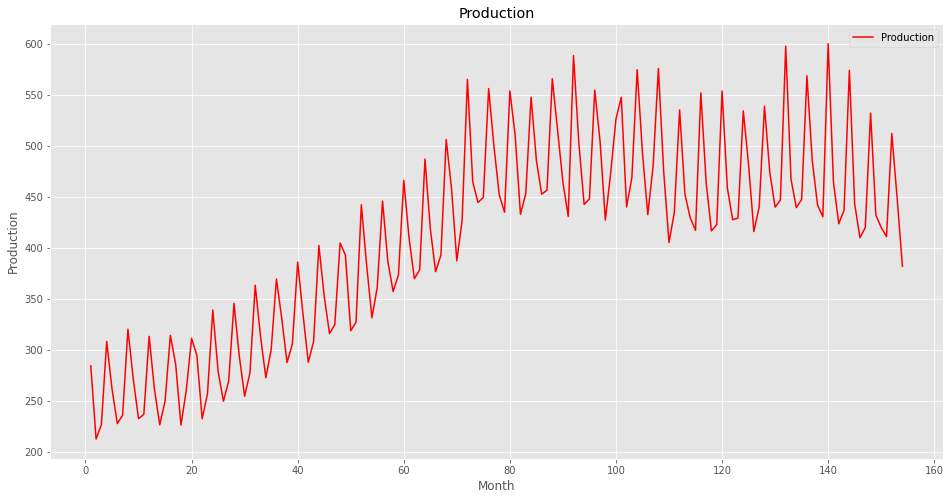

In [144]:
# read data of Australian Beer Production
ausbeerprod = np.genfromtxt("ausbeerquarterly.csv", delimiter = ",")
# get month and production  values
month= ausbeerprod[:,0].astype(int)
prod= ausbeerprod[:,1] 
plt.figure(figsize = (16, 8))
# the production data in red
plt.plot(month,prod, 'r') 
plt.xlabel("Month")
plt.ylabel("Production")
plt.title("Production")
plt.legend(['Production'])
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

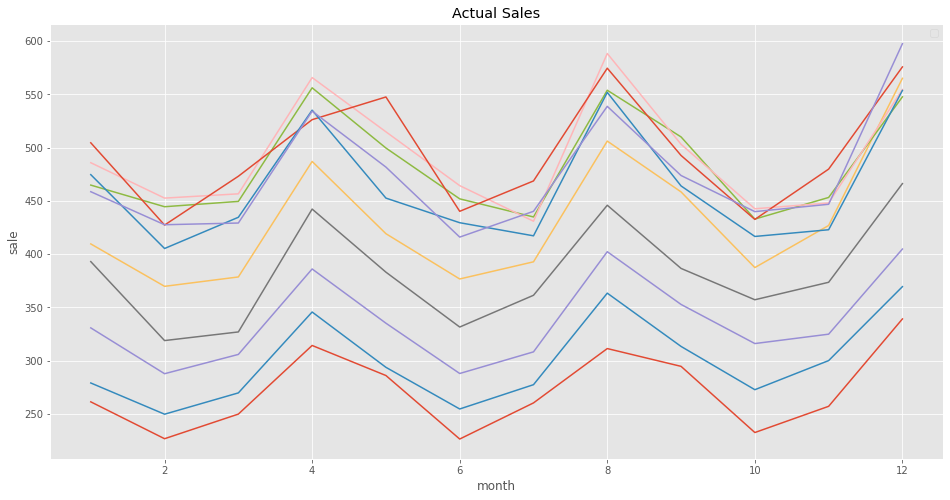

In [145]:
# plotting the 12 month seasonal figure 
#in order to investigating the seasonality
plt.figure(figsize = (16,8))
plt.xlabel("month")
plt.ylabel("sale")
plt.title("Actual Sales")
plt.legend(['Actual Sales'])
plt.show
for i in range(10):
    plt.plot(month[0:12],prod[(i+1)*12:(i+2)*12],label='$y = {i}x + {i}$'.format(i=i))
plt.show

#there is a seasonality
#and upward trend


In [146]:
# Fit a SARIMA(0,1,0)(0,1,0,4) model to the whole data
SARIMA = sm.tsa.statespace.SARIMAX(prod, trend ='c', order=(0, 1,0 ),
                                seasonal_order=(0, 1, 0, 4))
results_SARIMA = SARIMA.fit()
results_SARIMA.summary()
#seems like intercept term is not statistically significant

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  154
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 4)   Log Likelihood                -705.976
Date:                           Mon, 04 Apr 2022   AIC                           1415.953
Time:                                   19:19:00   BIC                           1421.961
Sample:                                        0   HQIC                          1418.394
                                           - 154                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.1047      2.283     -0.046      0.963      -4.579       4.370
sigma2       763.8084     78.855      9.686      0.000     609.255     918.361
===================================================================================
Ljung-Box (L1) (Q):                  55.25   Jarque-Bera (JB):                 2.99
Prob(Q):                              0.00   Prob(JB):                         0.22
Heteroskedasticity (H):               3.04   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [147]:
# Explore the significance of the fitted coefficients, 
# the residual diagnostics and 
# the error performance. 
predictions_SARIMA = results_SARIMA.get_prediction() 
#  computing y(t)-yhat(t)
error = prod - predictions_SARIMA.predicted_mean 
mse_check = np.mean(np.square(error))
# get the residuals array directly from the results table
mse = np.mean(np.square(results_SARIMA.resid)) 
rmse = np.sqrt(mse)
mae = np.mean(np.abs(results_SARIMA.resid))
mape = np.mean(np.abs(results_SARIMA.resid/prod))
print('SARIMA(0,1,0)(0,1,0,4) - MSE:{}'.format(mse))
print('SARIMA(0,1,0)(0,1,0,4) - MSE CHECK:{} '.format( mse_check))
print('SARIMA(0,1,0)(0,1,0,4) - RMSE:{} '.format( rmse))
print('SARIMA(0,1,0)(0,1,0,4) - MAE:{}  '.format( mae))
print('SARIMA(0,1,0)(0,1,0,4) - MAPE{}'.format( mape))
        

SARIMA(0,1,0)(0,1,0,4) - MSE:1573.0796424979053
SARIMA(0,1,0)(0,1,0,4) - MSE CHECK:1573.0796424979053 
SARIMA(0,1,0)(0,1,0,4) - RMSE:39.66206805624116 
SARIMA(0,1,0)(0,1,0,4) - MAE:24.989440059186688  
SARIMA(0,1,0)(0,1,0,4) - MAPE0.06466365799841431


In [148]:
#detrending the data 
drprod = np.diff(prod)
dsdrprod= np.zeros(len(drprod))
#deseazonilizing the data (4 month)
for i in range(4,len(drprod)):
    dsdrprod[i] =drprod[i]- drprod[i-4]



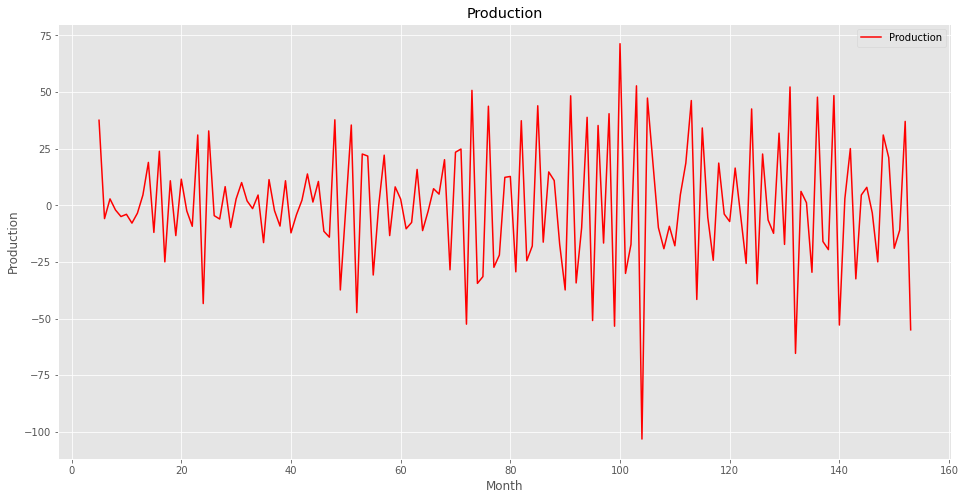

In [149]:
plt.figure(figsize = (16, 8))
# the production data in red
plt.plot(month[4:len(drprod)],dsdrprod[4:], 'r') 
plt.xlabel("Month")
plt.ylabel("Production")
plt.title("Production")
plt.legend(['Production'])
plt.show()

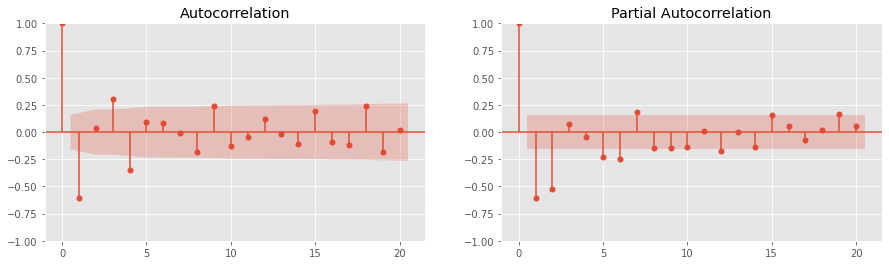

In [150]:
#plotting ACF and PACF of detrended data
fig, axes = plt.subplots(1, 2, figsize=(15,4))
fig = sm.graphics.tsa.plot_acf(dsdrprod, lags=20, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(dsdrprod, lags=20, ax=axes[1])

In [151]:
#Experiment with a different sarima ARIMA model for comparison
# Define the p, d and q parameters to take any value between 0 and 3
p = d = q = range(0, 3)
# Generate all different combinations of p, d and q triplets
pdq =[(x[0],1, x[1]) for x in list(itertools.product(p,q))]
print(pdq)
#since i observed no seasonaltiy Seasonal part OF ARIMA is (0,0,0,0)
seasonal_pdq = [(x[0], 1, x[2], 4) for x in list(itertools.product(p, d, q))]
print(dsdrprod)

[(0, 1, 0), (0, 1, 1), (0, 1, 2), (1, 1, 0), (1, 1, 1), (1, 1, 2), (2, 1, 0), (2, 1, 1), (2, 1, 2)]
[ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  3.750e+01 -5.900e+00
  2.800e+00 -2.100e+00 -5.000e+00 -4.000e+00 -7.900e+00 -3.500e+00
  4.500e+00  1.890e+01 -1.200e+01  2.380e+01 -2.500e+01  1.080e+01
 -1.340e+01  1.150e+01 -2.500e+00 -9.300e+00  3.100e+01 -4.340e+01
  3.280e+01 -4.600e+00 -6.100e+00  8.200e+00 -9.800e+00  2.800e+00
  1.000e+01  1.900e+00 -1.500e+00  4.500e+00 -1.650e+01  1.130e+01
 -2.400e+00 -9.200e+00  1.080e+01 -1.220e+01 -4.200e+00  2.200e+00
  1.380e+01  1.400e+00  1.050e+01 -1.150e+01 -1.410e+01  3.770e+01
 -3.740e+01 -7.000e-01  3.540e+01 -4.740e+01  2.260e+01  2.170e+01
 -3.080e+01 -1.000e-01  2.210e+01 -1.340e+01  8.100e+00  2.700e+00
 -1.040e+01 -7.600e+00  1.580e+01 -1.120e+01 -2.700e+00  7.300e+00
  4.900e+00  2.010e+01 -2.850e+01  2.340e+01  2.480e+01 -5.250e+01
  5.070e+01 -3.450e+01 -3.150e+01  4.370e+01 -2.740e+01 -2.200e+01
  1.230e+01  1.270e+01 -2.940

In [152]:
# Fit a model for each combination of the parameters
# and retrive, MAE MAPE and RMSE for each
# and compare with the previous models and take the best model
bestAIC=999999999
best_para_MAPE=list([0,0,0])
best_Spara_MAPE=list([0,0,0,0])
best_para_AIC=list([0,0,0])
bestMAPE=999999999
bestresults=0
warnings.filterwarnings("ignore")
for param in pdq:
    for param_seasonal in seasonal_pdq:       
        mod = sm.tsa.statespace.SARIMAX(prod, trend = 'c', order=param, seasonal_order=param_seasonal)
        results = mod.fit()
        predictions_ar2 = results.get_prediction() 
#  computing y(t)-yhat(t)
        error = prod - predictions_ar2.predicted_mean 
        mse_check = np.mean(np.square(error))
# get the residuals array directly from the results table
        mse = np.mean(np.square(results.resid)) 
        rmse = np.sqrt(mse)
        mae = np.mean(np.abs(results.resid))
        mape = np.mean(np.abs(results.resid/prod))
        print('ARIMA{}x{} - MSE:{}'.format(param, param_seasonal, mse) )
        print('ARIMA{}x{} - MSE CHECK:{} '.format(param, param_seasonal, mse_check))
        print('ARIMA{}x{} - RMSE:{} '.format(param, param_seasonal, rmse))
        print('ARIMA{}x{} - MAE:{}  '.format(param, param_seasonal, mae))
        print('ARIMA{}x{} - MAPE{}'.format(param, param_seasonal, mape))
        if mape<bestMAPE:
            bestMAPE=mape
            best_para_MAPE=param
            best_Spara_MAPE=param_seasonal
            bestresults = results
    

ARIMA(0, 1, 0)x(0, 1, 0, 4) - MSE:1573.0796424979053
ARIMA(0, 1, 0)x(0, 1, 0, 4) - MSE CHECK:1573.0796424979053 
ARIMA(0, 1, 0)x(0, 1, 0, 4) - RMSE:39.66206805624116 
ARIMA(0, 1, 0)x(0, 1, 0, 4) - MAE:24.989440059186688  
ARIMA(0, 1, 0)x(0, 1, 0, 4) - MAPE0.06466365799841431
ARIMA(0, 1, 0)x(0, 1, 1, 4) - MSE:1339.8741605306307
ARIMA(0, 1, 0)x(0, 1, 1, 4) - MSE CHECK:1339.8741605306307 
ARIMA(0, 1, 0)x(0, 1, 1, 4) - RMSE:36.60429155892285 
ARIMA(0, 1, 0)x(0, 1, 1, 4) - MAE:20.703773061140804  
ARIMA(0, 1, 0)x(0, 1, 1, 4) - MAPE0.05543297402797274
ARIMA(0, 1, 0)x(0, 1, 2, 4) - MSE:1332.4185767120566
ARIMA(0, 1, 0)x(0, 1, 2, 4) - MSE CHECK:1332.4185767120566 
ARIMA(0, 1, 0)x(0, 1, 2, 4) - RMSE:36.50230919698173 
ARIMA(0, 1, 0)x(0, 1, 2, 4) - MAE:20.7202947107042  
ARIMA(0, 1, 0)x(0, 1, 2, 4) - MAPE0.055251601131687506
ARIMA(0, 1, 0)x(0, 1, 0, 4) - MSE:1573.0796424979053
ARIMA(0, 1, 0)x(0, 1, 0, 4) - MSE CHECK:1573.0796424979053 
ARIMA(0, 1, 0)x(0, 1, 0, 4) - RMSE:39.66206805624116 
ARIMA(

ARIMA(0, 1, 1)x(0, 1, 2, 4) - MSE:1112.1102365544557
ARIMA(0, 1, 1)x(0, 1, 2, 4) - MSE CHECK:1112.1102365544557 
ARIMA(0, 1, 1)x(0, 1, 2, 4) - RMSE:33.348316847398095 
ARIMA(0, 1, 1)x(0, 1, 2, 4) - MAE:16.603727835700763  
ARIMA(0, 1, 1)x(0, 1, 2, 4) - MAPE0.045452589674596644
ARIMA(0, 1, 1)x(0, 1, 0, 4) - MSE:1196.7479788862345
ARIMA(0, 1, 1)x(0, 1, 0, 4) - MSE CHECK:1196.7479788862345 
ARIMA(0, 1, 1)x(0, 1, 0, 4) - RMSE:34.59404542527853 
ARIMA(0, 1, 1)x(0, 1, 0, 4) - MAE:18.72352057464203  
ARIMA(0, 1, 1)x(0, 1, 0, 4) - MAPE0.05007074753435864
ARIMA(0, 1, 1)x(0, 1, 1, 4) - MSE:1119.8770858622681
ARIMA(0, 1, 1)x(0, 1, 1, 4) - MSE CHECK:1119.8770858622681 
ARIMA(0, 1, 1)x(0, 1, 1, 4) - RMSE:33.46456462980309 
ARIMA(0, 1, 1)x(0, 1, 1, 4) - MAE:16.941836534825555  
ARIMA(0, 1, 1)x(0, 1, 1, 4) - MAPE0.04641943203351271
ARIMA(0, 1, 1)x(0, 1, 2, 4) - MSE:1112.1102365544557
ARIMA(0, 1, 1)x(0, 1, 2, 4) - MSE CHECK:1112.1102365544557 
ARIMA(0, 1, 1)x(0, 1, 2, 4) - RMSE:33.348316847398095 
ARI

ARIMA(0, 1, 2)x(1, 1, 0, 4) - MSE:1148.5017057340317
ARIMA(0, 1, 2)x(1, 1, 0, 4) - MSE CHECK:1148.5017057340317 
ARIMA(0, 1, 2)x(1, 1, 0, 4) - RMSE:33.889551571746 
ARIMA(0, 1, 2)x(1, 1, 0, 4) - MAE:17.594890225372808  
ARIMA(0, 1, 2)x(1, 1, 0, 4) - MAPE0.04769945204026203
ARIMA(0, 1, 2)x(1, 1, 1, 4) - MSE:1084.5178228617074
ARIMA(0, 1, 2)x(1, 1, 1, 4) - MSE CHECK:1084.5178228617074 
ARIMA(0, 1, 2)x(1, 1, 1, 4) - RMSE:32.93201820207361 
ARIMA(0, 1, 2)x(1, 1, 1, 4) - MAE:16.054141756265828  
ARIMA(0, 1, 2)x(1, 1, 1, 4) - MAPE0.044310353248404995
ARIMA(0, 1, 2)x(1, 1, 2, 4) - MSE:1078.0653929778932
ARIMA(0, 1, 2)x(1, 1, 2, 4) - MSE CHECK:1078.0653929778932 
ARIMA(0, 1, 2)x(1, 1, 2, 4) - RMSE:32.833906148642946 
ARIMA(0, 1, 2)x(1, 1, 2, 4) - MAE:15.888178019989166  
ARIMA(0, 1, 2)x(1, 1, 2, 4) - MAPE0.043900916202349344
ARIMA(0, 1, 2)x(1, 1, 0, 4) - MSE:1148.5017057340317
ARIMA(0, 1, 2)x(1, 1, 0, 4) - MSE CHECK:1148.5017057340317 
ARIMA(0, 1, 2)x(1, 1, 0, 4) - RMSE:33.889551571746 
ARIMA(

ARIMA(1, 1, 0)x(1, 1, 1, 4) - MSE:1140.903378086245
ARIMA(1, 1, 0)x(1, 1, 1, 4) - MSE CHECK:1140.903378086245 
ARIMA(1, 1, 0)x(1, 1, 1, 4) - RMSE:33.77726125792683 
ARIMA(1, 1, 0)x(1, 1, 1, 4) - MAE:17.010674023638128  
ARIMA(1, 1, 0)x(1, 1, 1, 4) - MAPE0.04647034278184067
ARIMA(1, 1, 0)x(1, 1, 2, 4) - MSE:1126.4077786660723
ARIMA(1, 1, 0)x(1, 1, 2, 4) - MSE CHECK:1126.4077786660723 
ARIMA(1, 1, 0)x(1, 1, 2, 4) - RMSE:33.561999026668126 
ARIMA(1, 1, 0)x(1, 1, 2, 4) - MAE:16.77520851423733  
ARIMA(1, 1, 0)x(1, 1, 2, 4) - MAPE0.04597755869663063
ARIMA(1, 1, 0)x(1, 1, 0, 4) - MSE:1224.3246494538766
ARIMA(1, 1, 0)x(1, 1, 0, 4) - MSE CHECK:1224.3246494538766 
ARIMA(1, 1, 0)x(1, 1, 0, 4) - RMSE:34.99035080495588 
ARIMA(1, 1, 0)x(1, 1, 0, 4) - MAE:18.884862605388072  
ARIMA(1, 1, 0)x(1, 1, 0, 4) - MAPE0.05057265151295886
ARIMA(1, 1, 0)x(1, 1, 1, 4) - MSE:1140.903378086245
ARIMA(1, 1, 0)x(1, 1, 1, 4) - MSE CHECK:1140.903378086245 
ARIMA(1, 1, 0)x(1, 1, 1, 4) - RMSE:33.77726125792683 
ARIMA(1, 

ARIMA(1, 1, 1)x(1, 1, 1, 4) - MSE:1091.0563162400422
ARIMA(1, 1, 1)x(1, 1, 1, 4) - MSE CHECK:1091.0563162400422 
ARIMA(1, 1, 1)x(1, 1, 1, 4) - RMSE:33.031141612727254 
ARIMA(1, 1, 1)x(1, 1, 1, 4) - MAE:16.136027277673406  
ARIMA(1, 1, 1)x(1, 1, 1, 4) - MAPE0.04436357123344998
ARIMA(1, 1, 1)x(1, 1, 2, 4) - MSE:1082.7496029391439
ARIMA(1, 1, 1)x(1, 1, 2, 4) - MSE CHECK:1082.7496029391439 
ARIMA(1, 1, 1)x(1, 1, 2, 4) - RMSE:32.90516073413324 
ARIMA(1, 1, 1)x(1, 1, 2, 4) - MAE:15.847862164093154  
ARIMA(1, 1, 1)x(1, 1, 2, 4) - MAPE0.04375041959392194
ARIMA(1, 1, 1)x(2, 1, 0, 4) - MSE:1105.1471996194255
ARIMA(1, 1, 1)x(2, 1, 0, 4) - MSE CHECK:1105.1471996194255 
ARIMA(1, 1, 1)x(2, 1, 0, 4) - RMSE:33.243754294896135 
ARIMA(1, 1, 1)x(2, 1, 0, 4) - MAE:16.82690639788789  
ARIMA(1, 1, 1)x(2, 1, 0, 4) - MAPE0.04583441886697077
ARIMA(1, 1, 1)x(2, 1, 1, 4) - MSE:1088.2909991440215
ARIMA(1, 1, 1)x(2, 1, 1, 4) - MSE CHECK:1088.2909991440215 
ARIMA(1, 1, 1)x(2, 1, 1, 4) - RMSE:32.98925581373459 
ARIM

ARIMA(1, 1, 2)x(2, 1, 1, 4) - MSE:1081.8603355735754
ARIMA(1, 1, 2)x(2, 1, 1, 4) - MSE CHECK:1081.8603355735754 
ARIMA(1, 1, 2)x(2, 1, 1, 4) - RMSE:32.891645376502154 
ARIMA(1, 1, 2)x(2, 1, 1, 4) - MAE:16.052912864906727  
ARIMA(1, 1, 2)x(2, 1, 1, 4) - MAPE0.04434160189618623
ARIMA(1, 1, 2)x(2, 1, 2, 4) - MSE:1081.2664484012425
ARIMA(1, 1, 2)x(2, 1, 2, 4) - MSE CHECK:1081.2664484012425 
ARIMA(1, 1, 2)x(2, 1, 2, 4) - RMSE:32.88261620372142 
ARIMA(1, 1, 2)x(2, 1, 2, 4) - MAE:16.041182960087845  
ARIMA(1, 1, 2)x(2, 1, 2, 4) - MAPE0.044290777678537334
ARIMA(1, 1, 2)x(2, 1, 0, 4) - MSE:1102.9319725580108
ARIMA(1, 1, 2)x(2, 1, 0, 4) - MSE CHECK:1102.9319725580108 
ARIMA(1, 1, 2)x(2, 1, 0, 4) - RMSE:33.21041963839076 
ARIMA(1, 1, 2)x(2, 1, 0, 4) - MAE:16.81074925021033  
ARIMA(1, 1, 2)x(2, 1, 0, 4) - MAPE0.0458349841595283
ARIMA(1, 1, 2)x(2, 1, 1, 4) - MSE:1081.8603355735754
ARIMA(1, 1, 2)x(2, 1, 1, 4) - MSE CHECK:1081.8603355735754 
ARIMA(1, 1, 2)x(2, 1, 1, 4) - RMSE:32.891645376502154 
ARIM

ARIMA(2, 1, 0)x(2, 1, 1, 4) - MSE:1085.2646509531626
ARIMA(2, 1, 0)x(2, 1, 1, 4) - MSE CHECK:1085.2646509531626 
ARIMA(2, 1, 0)x(2, 1, 1, 4) - RMSE:32.94335518664064 
ARIMA(2, 1, 0)x(2, 1, 1, 4) - MAE:16.13537796377233  
ARIMA(2, 1, 0)x(2, 1, 1, 4) - MAPE0.04459797541096447
ARIMA(2, 1, 0)x(2, 1, 2, 4) - MSE:1084.4948434419166
ARIMA(2, 1, 0)x(2, 1, 2, 4) - MSE CHECK:1084.4948434419166 
ARIMA(2, 1, 0)x(2, 1, 2, 4) - RMSE:32.93166930846228 
ARIMA(2, 1, 0)x(2, 1, 2, 4) - MAE:16.142301737666727  
ARIMA(2, 1, 0)x(2, 1, 2, 4) - MAPE0.044619727315598774
ARIMA(2, 1, 0)x(2, 1, 0, 4) - MSE:1105.1901697739816
ARIMA(2, 1, 0)x(2, 1, 0, 4) - MSE CHECK:1105.1901697739816 
ARIMA(2, 1, 0)x(2, 1, 0, 4) - RMSE:33.24440057775116 
ARIMA(2, 1, 0)x(2, 1, 0, 4) - MAE:16.764602260228774  
ARIMA(2, 1, 0)x(2, 1, 0, 4) - MAPE0.04589406831757875
ARIMA(2, 1, 0)x(2, 1, 1, 4) - MSE:1085.2646509531626
ARIMA(2, 1, 0)x(2, 1, 1, 4) - MSE CHECK:1085.2646509531626 
ARIMA(2, 1, 0)x(2, 1, 1, 4) - RMSE:32.94335518664064 
ARIMA

ARIMA(2, 1, 1)x(2, 1, 1, 4) - MSE:1081.8924170306607
ARIMA(2, 1, 1)x(2, 1, 1, 4) - MSE CHECK:1081.8924170306607 
ARIMA(2, 1, 1)x(2, 1, 1, 4) - RMSE:32.89213305686727 
ARIMA(2, 1, 1)x(2, 1, 1, 4) - MAE:16.052157606361696  
ARIMA(2, 1, 1)x(2, 1, 1, 4) - MAPE0.04432515658486842
ARIMA(2, 1, 1)x(2, 1, 2, 4) - MSE:1077.5966078351387
ARIMA(2, 1, 1)x(2, 1, 2, 4) - MSE CHECK:1077.5966078351387 
ARIMA(2, 1, 1)x(2, 1, 2, 4) - RMSE:32.8267666369251 
ARIMA(2, 1, 1)x(2, 1, 2, 4) - MAE:15.890142827044178  
ARIMA(2, 1, 1)x(2, 1, 2, 4) - MAPE0.043887260338545016
ARIMA(2, 1, 2)x(0, 1, 0, 4) - MSE:1151.352702189835
ARIMA(2, 1, 2)x(0, 1, 0, 4) - MSE CHECK:1151.352702189835 
ARIMA(2, 1, 2)x(0, 1, 0, 4) - RMSE:33.931588559774724 
ARIMA(2, 1, 2)x(0, 1, 0, 4) - MAE:17.682451057318964  
ARIMA(2, 1, 2)x(0, 1, 0, 4) - MAPE0.04796954436964422
ARIMA(2, 1, 2)x(0, 1, 1, 4) - MSE:1084.8968286578674
ARIMA(2, 1, 2)x(0, 1, 1, 4) - MSE CHECK:1084.8968286578674 
ARIMA(2, 1, 2)x(0, 1, 1, 4) - RMSE:32.937772065788955 
ARIMA

In [153]:
print("Trend Part: ", best_para_MAPE)
print("Seasonal Part: ",best_Spara_MAPE)
print(bestresults.summary())

Trend Part:  (1, 1, 1)
Seasonal Part:  (1, 1, 2, 4)
                                       SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                  154
Model:             SARIMAX(1, 1, 1)x(1, 1, [1, 2], 4)   Log Likelihood                -624.871
Date:                                Mon, 04 Apr 2022   AIC                           1263.742
Time:                                        19:20:20   BIC                           1284.769
Sample:                                             0   HQIC                          1272.285
                                                - 154                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.2541      0.3

In [154]:
# creating an array that is equal to prod array
# but this array has bigger size than prod array
# so that I will use the parameters which I found for my best model above
# to estimate 155th prediction
predicting_155_month= np.zeros(len(prod)+40)
for i in range(len(predicting_155_month)):
    predicting_155_month[i]=i+1

predicting_155= np.zeros(len(prod)+40)
for i in range(len(prod)):
    predicting_155[i]=prod[i]

    
    
#uses same ARIMA model       
mod_dwtest = sm.tsa.statespace.SARIMAX(predicting_155, trend ='c',  order=(1,1,1) , seasonal_order=(1,1,2,4))
# use the parameters estimated from the original data which became training set
res_dwtest = mod_dwtest.filter(bestresults.params) 
#use dynamic attribute to compute other time slots after 154th
res_dwtest = res_dwtest.get_prediction(dynamic=153)
predictions_ar2 = res_dwtest.predicted_mean

#print prediction
print("Prediction:", predictions_ar2[154])
#print confidence interval
print("Confidence interval",res_dwtest.conf_int()[154])






Prediction: 401.97323890891664
Confidence interval [371.10924945 432.83722837]


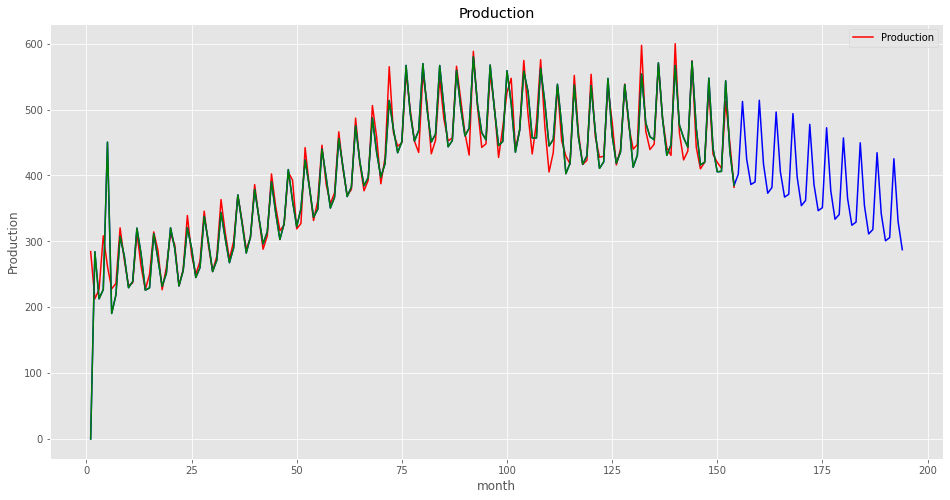

In [155]:
#
# PLOT THE FIGURE SHOWING THE PREDICTIONS AFTER 154TH TIME SLOT
#
plt.figure(figsize = (16, 8))
plt.plot(month,prod, 'r') # the real production data in red
plt.plot(predicting_155_month,predictions_ar2, 'b') # the predictions after 154th mont
plt.plot(month,bestresults.get_prediction().predicted_mean, 'g')  # one-step ahead predictions using all data available 
plt.xlabel("month")
plt.ylabel("Production")
plt.title("Production")
plt.legend(['Production'])
plt.show()

In [156]:
#fitting a model on training set
mod_dwtest = sm.tsa.statespace.SARIMAX(prod[0:113], trend ='c',  order=(1,1,1) , seasonal_order=(1,1,2,4))

results=  mod_dwtest.fit(disp=False)
# fitting a model using training set parameters on testing set
# testing on testing set
mod_dwtest = sm.tsa.statespace.SARIMAX(prod[113:], trend ='c',  order=(1,1,1) , seasonal_order=(1,1,2,4))
res_dwtest = mod_dwtest.filter(results.params) # use the parameters estimated from the training data
res_dwtest.summary() # the model that was estimated on the training set

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                   41
Model:             SARIMAX(1, 1, 1)x(1, 1, [1, 2], 4)   Log Likelihood                -155.824
Date:                                Mon, 04 Apr 2022   AIC                            325.649
Time:                                        19:20:21   BIC                            336.734
Sample:                                             0   HQIC                           329.518
                                                 - 41                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.3437      1.094     -0.314      0.753      -2.487       1.800
ar.L1         -0.3642      0.158     -2.312      0.021      -0.673      -0.055
ma.L1         -0.5409      0.195     -2.775      0.006      -0.923      -0.159
ar.S.L4       -0.6162      0.300     -2.056      0.040      -1.204      -0.029
ma.S.L4        0.2033      0.535      0.380      0.704      -0.846       1.253
ma.S.L8       -0.6793      0.345     -1.971      0.049      -1.355      -0.004
sigma2       224.2755     59.025      3.800      0.000     108.589     339.962
===================================================================================
Ljung-Box (L1) (Q):                   1.33   Jarque-Bera (JB):                 0.17
Prob(Q):                              0.25   Prob(JB):                         0.92
Heteroskedasticity (H):               1.66   Skew:                             0.17
Prob(H) (two-sided):                  0.39   Kurtosis:                         2.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [157]:
# Error measures on test set
predict_dw = res_dwtest.get_prediction() 
mse_dw = np.mean(np.square(res_dwtest.resid))
rmse_dw = np.sqrt(mse_dw)
mae_dw = np.mean(np.abs(res_dwtest.resid))
mape_dw = np.mean(np.abs(res_dwtest.resid)/prod[113:])
print('MSE Beer = ', mse_dw)
print('RMSE Beer  = ', rmse_dw)
print('MAE Beer= ', mae_dw)
print('MAPE Beer= ', mape_dw)

MSE Beer =  7086.763998857391
RMSE Beer  =  84.18291987604962
MAE Beer=  35.32766841257454
MAPE Beer=  0.07787323112330123


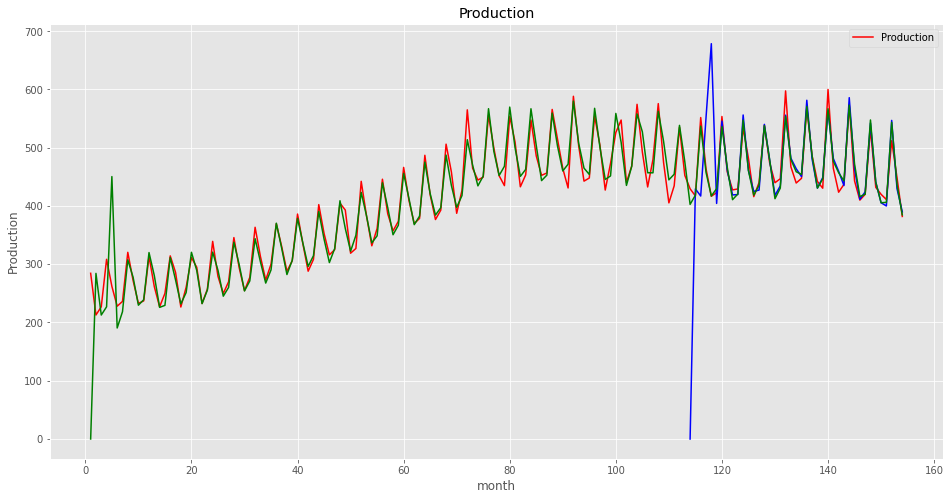

In [158]:
# We can now plot the data from mpnth 40 onwards 
predict_beer3 = bestresults.get_prediction()
plt.figure(figsize = (16, 8))
plt.plot(month,prod, 'r') # the production data in red
plt.plot(month[113:],res_dwtest.get_prediction().predicted_mean, 'b') # the predictions on test set
plt.plot(month,bestresults.get_prediction().predicted_mean, 'g') # one-step ahead predictions using all data available 
#up to month t-1 to predict month t (in green)

plt.xlabel("month")
plt.ylabel("Production")
plt.title("Production")
plt.legend(['Production'])
plt.show()

In [159]:
df = pd.read_csv('ausbeerquarterly_dummies.csv', index_col=0) # let's data into dataframe df
df.head() # and take a look at the header of the data frame.

,Production,t,M1,M2,M3
Month,,,,,
1,284.4,1,1,0,0
2,212.8,2,0,1,0
3,226.9,3,0,0,1
4,308.4,4,0,0,0
5,262.0,5,1,0,0


In [160]:
# fit the model with 3 month dummmies

model_beer = sm.OLS.from_formula('Production ~  M1 +M2 +M3 ', df[:153])
result1 = model_beer.fit()
result1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Production   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.194
Method:                 Least Squares   F-statistic:                     13.19
Date:                Mon, 04 Apr 2022   Prob (F-statistic):           1.11e-07
Time:                        19:20:21   Log-Likelihood:                -899.92
No. Observations:                 153   AIC:                             1808.
Df Residuals:                     149   BIC:                             1820.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    479.7684     14.259     33.648      0.000     451.593     507.943
M1           -67.3300     20.035     -3.361      0.001    -106.919     -27.741
M2          -115.8447     20.165     -5.745      0.000    -155.690     -75.999
M3          -102.2474     20.165     -5.071      0.000    -142.093     -62.402
==============================================================================
Omnibus:                       57.617   Durbin-Watson:                   0.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               16.728
Skew:                          -0.569   Prob(JB):                     0.000233
Kurtosis:                       1.846   Cond. No.                         4.81
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [161]:
# fit the model with a trend term and 3 month dummmies

model_beer = sm.OLS.from_formula('Production ~ t + M1 +M2 +M3 ', df[:153])
result2 = model_beer.fit()
result2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Production   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     139.5
Date:                Mon, 04 Apr 2022   Prob (F-statistic):           3.59e-49
Time:                        19:20:21   Log-Likelihood:                -798.39
No. Observations:                 153   AIC:                             1607.
Df Residuals:                     148   BIC:                             1622.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    348.4431      9.816     35.498      0.000     329.046     367.840
t              1.6837      0.083     20.249      0.000       1.519       1.848
M1           -65.6463     10.353     -6.341      0.000     -86.105     -45.187
M2          -112.4774     10.421    -10.793      0.000    -133.071     -91.884
M3          -100.5637     10.420     -9.651      0.000    -121.155     -79.972
==============================================================================
Omnibus:                        4.867   Durbin-Watson:                   0.295
Prob(Omnibus):                  0.088   Jarque-Bera (JB):                3.649
Skew:                           0.249   Prob(JB):                        0.161
Kurtosis:                       2.431   Cond. No.                         397.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [162]:
# make 1 step ahead forecast for each
dftest=df[154:]

In [163]:
# a one-quarter ahead forecast for quarter 155  with 3 month dummmies
result1.predict(dftest)

Month
155    377.521053
dtype: float64

In [164]:
 # the residuals on the one-quarter ahead forecast for quarter 155  with 3 month dummmies
# compute MSE and RMSE from residuals
mse1= np.mean(np.square(result1.resid))
rmse1 = np.sqrt(mse1)
print('MSE 1 =', mse1)
print('RMSE 1 =', rmse1)

MSE 1 = 7523.626446111508
RMSE 1 = 86.73884047018099


In [165]:
print("Lower Prediction interval =",377.521053-(rmse1*1.96))
print("Upper Prediction interval =",377.521053+(rmse1*1.96))

Lower Prediction interval = 207.51292567844527
Upper Prediction interval = 547.5291803215547


In [166]:
#  a one-quarter ahead forecast for quarter 155 with trend and 3 month dummmies
result2.predict(dftest)

Month
155    508.84634
dtype: float64

In [167]:
 # the residuals on the one-quarter ahead forecast for quarter 155  with trend and 3 month dummmies
# compute MSE from residuals
mse2= np.mean(np.square(result2.resid))
rmse2 = np.sqrt(mse2)
print('MSE 2 =', mse2)
print('RMSE 2 =', rmse2)

MSE 2 = 1995.4744909567983
RMSE 2 = 44.670734166306225


In [168]:
print("Lower Prediction interval =",377.521053-(rmse2*1.96))
print("Upper Prediction interval =",377.521053+(rmse2*1.96))

Lower Prediction interval = 289.9664140340398
Upper Prediction interval = 465.0756919659602
